In [2]:
from vit_pipeline.utils import make_container_dict
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import os
import pickle

load_dotenv()

allen_cache_path = os.environ.get('HGMS_ALLEN_CACHE_PATH')
boc = BrainObservatoryCache(manifest_file=str(Path(allen_cache_path) / Path('brain_observatory_manifest.json')))

experiment_containers = make_container_dict(boc)

session_A=experiment_containers[643061996]['three_session_A']
data_set_events= boc.get_ophys_experiment_events(session_A)

dat = boc.get_ophys_experiment_data(session_A)
stim_table = dat.get_stimulus_table('natural_movie_one')

transformer_embedding_path = Path("/home/maria/Documents/HuggingMouseData/TransformerEmbeddings/google_vit-base-patch16-224_embeddings.pkl") 
        # Load the transformer embeddings
with open(transformer_embedding_path, 'rb') as file:
    transfr = pickle.load(file)
embedding = transfr['natural_movie_one']  # Shape: (total_time_points, embedding_dim)
embedding_dim = embedding.shape[1]

first_trial=stim_table[0:900]

all_cells=data_set_events[:,first_trial['start']]

v=all_cells.T
X=embedding

filtered=v.T@X

In [11]:
spearmanr(filtered)[0].shape

(768, 768)

(85264,)


/home/maria/MousePipeline/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/maria/MousePipeline/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


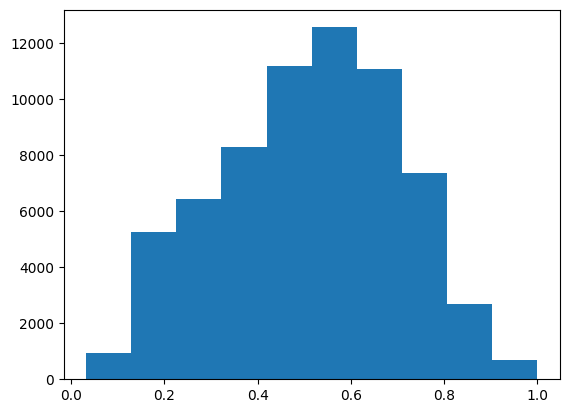

In [12]:
from scipy.stats import spearmanr, pearsonr
plt.hist(spearmanr(filtered.T)[0].flatten())
print(spearmanr(filtered.T)[0].flatten().shape)

/home/maria/MousePipeline/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/maria/MousePipeline/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(array([  996.,  4990.,  6024.,  7700., 10530., 12584., 11498.,  8272.,
         3228.,   742.]),
 array([0.03710887, 0.13339798, 0.22968709, 0.32597621, 0.42226532,
        0.51855443, 0.61484355, 0.71113266, 0.80742177, 0.90371089,
        1.        ]),
 <BarContainer object of 10 artists>)

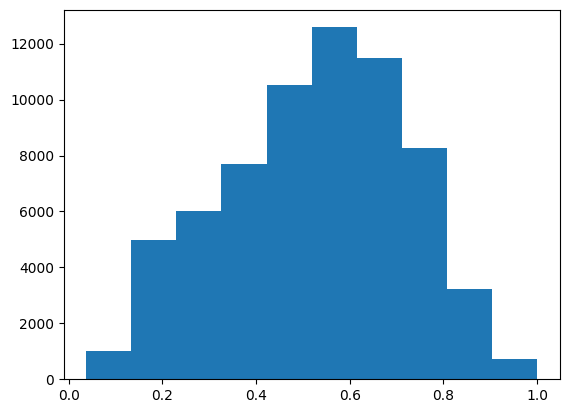

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming filtered is MxN where M > 2
pearson_corr_matrix = np.corrcoef(filtered)

plt.hist(pearson_corr_matrix.flatten())

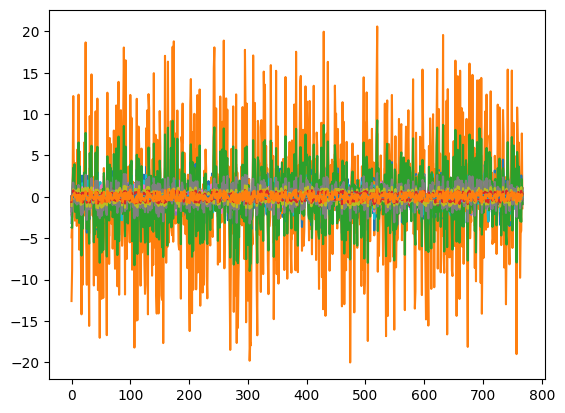

In [8]:
plt.plot(filtered.T)

In [13]:
filtered.shape

(292, 768)

In [14]:
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel
import torch
import numpy as np
import requests

# Load the pretrained ViT model
model_name = 'google/vit-base-patch16-224'
vit_model = ViTModel.from_pretrained(model_name)  # Model without classification head
vit_classifier = ViTForImageClassification.from_pretrained(model_name)  # Includes classification head
vit_classifier.eval()  # Set to evaluation mode

# Move models to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model.to(device)
vit_classifier.to(device)

# Simulated `filtered` array (replace with actual `filtered` data)
# Ensure dimensions match CLS token size (e.g., 768 for ViT-base)
#filtered = np.random.rand(10, vit_model.config.hidden_size)  # Example data

# Convert `filtered` to a PyTorch tensor
filtered_tensor = torch.tensor(filtered, dtype=torch.float32).to(device)

# Pass `filtered` as the CLS token through the classification head
with torch.no_grad():
    # Extract logits from the classification head using the filtered CLS tokens
    logits = vit_classifier.classifier(filtered_tensor)  # Directly classify the CLS tokens

# Get the predicted class indices
predicted_class_indices = torch.argmax(logits, dim=1).cpu().numpy()

# Download ImageNet class index mapping
response = requests.get("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json")
imagenet_class_mapping = {int(k): v for k, v in response.json().items()}

# Map class indices to human-readable labels
predicted_class_labels = [imagenet_class_mapping[idx][1] for idx in predicted_class_indices]

# Print results
for i, (cls_idx, cls_label) in enumerate(zip(predicted_class_indices, predicted_class_labels)):
    print(f"Row {i}: Predicted Class Index = {cls_idx}, Class Label = {cls_label}")


/home/maria/MousePipeline/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Row 0: Predicted Class Index = 852, Class Label = tennis_ball
Row 1: Predicted Class Index = 738, Class Label = pot
Row 2: Predicted Class Index = 561, Class Label = forklift
Row 3: Predicted Class Index = 413, Class Label = assault_rifle
Row 4: Predicted Class Index = 733, Class Label = pole
Row 5: Predicted Class Index = 1, Class Label = goldfish
Row 6: Predicted Class Index = 522, Class Label = croquet_ball
Row 7: Predicted Class Index = 923, Class Label = plate
Row 8: Predicted Class Index = 898, Class Label = water_bottle
Row 9: Predicted Class Index = 968, Class Label = cup
Row 10: Predicted Class Index = 763, Class Label = revolver
Row 11: Predicted Class Index = 923, Class Label = plate
Row 12: Predicted Class Index = 738, Class Label = pot
Row 13: Predicted Class Index = 968, Class Label = cup
Row 14: Predicted Class Index = 663, Class Label = monastery
Row 15: Predicted Class Index = 733, Class Label = pole
Row 16: Predicted Class Index = 738, Class Label = pot
Row 17: Predic